# Localization Loss



In [1]:
import tensorflow as tf

In [2]:
%load_ext autoreload
%autoreload 2

import sys
 
# setting path
sys.path.append('../read_data/')
sys.path.append('../')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import cv2

In [7]:
# Assuse we have a 8 x 8 box divided into 2 x 2 prior boxes

image_size = 32
boxes = []
prior_boxes = []
default_box_size  = 4

for i in range(0, image_size // default_box_size,):
    for j in range(0, image_size // default_box_size):
        boxes.append([ j * default_box_size, i * default_box_size, 
                            (j + 1) * default_box_size, (i + 1) * default_box_size ])
        prior_boxes.append( [ j * default_box_size + default_box_size // 2, i * default_box_size + default_box_size // 2, default_box_size, default_box_size ] )
        
# gt_boxes = [6, 6, 14, 13]
# gt_boxes = [[4, 4, 9, 9], [9, 9, 14 , 14], [24, 24, 29, 29]]

# boxes with IOU < 0.5
# gt_boxes = [[4, 4, 11, 11], [9, 9, 14 , 14], [24, 24, 31, 31]]
# gt_labels = [1, 2, 1]

# defaul box
gt_boxes = [[0, 0, 32, 32]]
gt_labels = [0]

In [8]:
prior_boxes[54]

[26, 26, 4, 4]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


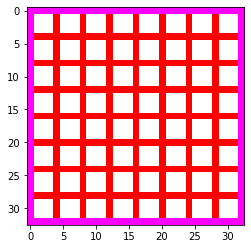

In [9]:
image = np.ones((image_size + 1, image_size + 1, 3))

for box in boxes:
    
    start_x, start_y, end_x, end_y = box
    
    image = cv2.rectangle(image, [start_x, start_y], [end_x, end_y], (255, 0 , 0), thickness = 1)

for box in gt_boxes:
    
    start_x, start_y, end_x, end_y = box  
    image = cv2.rectangle(image, [start_x, start_y], [end_x, end_y], (255, 0, 255), thickness = 1)

plt.imshow(image)

In [10]:
boxes = np.array(boxes, np.float32) / image_size
prior_boxes = np.array(prior_boxes, np.float32) / image_size
gt_boxes = np.array([gt_boxes], np.float32) / image_size
gt_labels = [0]

In [11]:
gt_boxes

array([[[0., 0., 1., 1.]]], dtype=float32)

In [12]:
print(prior_boxes.shape)
print(boxes.shape)
print(gt_boxes.shape)

(64, 4)
(64, 4)
(1, 1, 4)


In [13]:
from bbox_utils import box_overlap_iou, convert_to_centre_dimensions_form, calculate_offset_from_gt

In [14]:
box_x_min, box_y_min, box_x_max, box_y_max = tf.split(boxes, 4, axis = 1)
gt_boxes_x_min, gt_boxes_y_min, gt_boxes_x_max, gt_boxes_y_max = tf.split(gt_boxes, 4, axis = 2)

intersection_x_min = tf.maximum(box_x_min, tf.transpose(gt_boxes_x_min, perm=[0, 2, 1]))
intersection_y_min = tf.maximum(box_y_min, tf.transpose(gt_boxes_y_min, perm=[0, 2, 1]))

intersection_x_max = tf.minimum(box_x_max, tf.transpose(gt_boxes_x_max, perm=[0, 2, 1]))
intersection_y_max = tf.minimum(box_y_max, tf.transpose(gt_boxes_y_max, perm=[0, 2, 1]))

# need to take care of boxes that don't overlap at all
intersection_area = tf.maximum(intersection_x_max - intersection_x_min, 0) * tf.maximum(intersection_y_max - intersection_y_min, 0)

boxes_areas = (box_x_max - box_x_min) * (box_y_max - box_y_min)
gt_box_areas = (gt_boxes_x_max - gt_boxes_x_min) * (gt_boxes_y_max - gt_boxes_y_min)

union = (boxes_areas + tf.transpose(gt_box_areas, perm=[0, 2, 1])) - intersection_area

2022-09-05 00:45:36.562737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# union

In [16]:
threshold = 0.5
number_of_labels = 3

In [17]:
# number of rows for the IOU map the is the number of gt_boxes
IOU_map = box_overlap_iou(boxes, gt_boxes)

# convert ground boxes labels to box label format
gt_box_label = convert_to_centre_dimensions_form(gt_boxes)

# select the box with the highest IOU
highest_overlap_idx = tf.math.argmax(IOU_map, axis = 1)
highest_overlap_idx = tf.cast(highest_overlap_idx, tf.int32)
idx = tf.range(IOU_map.shape[1])
highest_overlap_idx_map = tf.expand_dims(tf.equal(idx, tf.transpose(highest_overlap_idx)), axis = 0)
IOU_map = tf.where(tf.transpose(highest_overlap_idx_map, perm=[0,2,1]), tf.constant(1.0), IOU_map)

# find the column idx with the highest IOU at each row
max_IOU_idx_per_row = tf.math.argmax(IOU_map, axis = 2)
# find the max value per row
max_IOU_per_row = tf.reduce_max(IOU_map, axis = 2)

# threshold IOU
max_IOU_above_threshold = tf.greater(max_IOU_per_row, threshold)

# map the gt boxes to the prior boxes with the highest overlap
gt_box_label_map = tf.gather(gt_box_label, max_IOU_idx_per_row, batch_dims = 1)
# get the offset, offcet (delta_cx, delta_cy, delta_width, delta_height)
gt_box_label_map_offsets = calculate_offset_from_gt(gt_box_label_map, prior_boxes)
# remove from gt_boxes_map where overlap with prior boxes is less than 0.5
gt_boxes_map_offset_suppressed = tf.where( tf.expand_dims(max_IOU_above_threshold, -1),  
                                    gt_box_label_map_offsets, tf.zeros_like(gt_box_label_map))
# add a positive condition column for the localization loss
max_IOU_above_threshold_expand = tf.expand_dims(max_IOU_above_threshold, -1)
max_IOU_above_threshold_expand = tf.cast(max_IOU_above_threshold_expand, tf.float32)
gt_boxes_map_offset_suppressed_with_pos_cond = tf.concat([  gt_boxes_map_offset_suppressed, 
                                                            max_IOU_above_threshold_expand ], axis = 2)

gt_labels_map = tf.gather(gt_labels, max_IOU_idx_per_row, batch_dims = 0)
# suppress the label where IOU with the gt boxes is < 0.5
gt_labels_map_suppressed = tf.where( max_IOU_above_threshold, 
                                    gt_labels_map, tf.zeros_like(gt_labels_map))
gt_labels_one_hot_encoded = tf.one_hot(gt_labels_map_suppressed, number_of_labels)

In [18]:
gt_labels_map_suppressed

<tf.Tensor: shape=(1, 64), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>

In [19]:
highest_overlap_idx = tf.math.argmax(IOU_map, axis = 1)
highest_overlap_idx = tf.cast(highest_overlap_idx, tf.int32)

highest_overlap_idx

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[0]], dtype=int32)>

In [20]:
max_IOU_above_threshold = tf.greater(max_IOU_per_row, threshold)
idx = tf.range(IOU_map.shape[1])
highest_overlap_idx_map = tf.expand_dims(tf.equal(idx, tf.transpose(highest_overlap_idx)), axis = 0)
IOU_map = tf.where(tf.transpose(highest_overlap_idx_map, perm=[0,2,1]), tf.constant(1.0), IOU_map)

In [21]:
tf.transpose(highest_overlap_idx_map, perm=[0,2,1])

<tf.Tensor: shape=(1, 64, 1), dtype=bool, numpy=
array([[[ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],

In [22]:
idx = tf.range(IOU_map.shape[1])
tf.expand_dims(tf.equal(idx, tf.transpose(highest_overlap_idx)), axis = 0)

<tf.Tensor: shape=(1, 1, 64), dtype=bool, numpy=
array([[[ True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False]]])>

In [23]:
highest_overlap_idx = tf.math.argmax(IOU_map, axis = 1)

highest_overlap_idx = tf.cast(highest_overlap_idx, tf.int32)

In [24]:
highest_overlap_idx

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[0]], dtype=int32)>

In [25]:
tf.not_equal(highest_overlap_idx, tf.constant(0))

<tf.Tensor: shape=(1, 1), dtype=bool, numpy=array([[False]])>

In [26]:
gt_box_label_map[0, 0, :]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.5, 0.5, 1. , 1. ], dtype=float32)>

In [27]:
prior_boxes_testing = tf.expand_dims(prior_boxes, axis=0)
# (gt_box_label_map[:, :, 0] - prior_boxes_testing[:, :, 0]) / prior_boxes_testing[:, :, 0]

g_j_cx = (gt_box_label_map[:, :, 0] - prior_boxes_testing[:, :, 0]) / prior_boxes_testing[:, :, 2]
g_j_cy = (gt_box_label_map[:, :, 1] - prior_boxes_testing[:, :, 1]) / prior_boxes_testing[:, :, 3]
g_j_w = tf.math.log(gt_box_label_map[:, :, 2] / prior_boxes_testing[:, :, 2])
g_j_h = tf.math.log(gt_box_label_map[:, :, 3] / prior_boxes_testing[:, :, 3])

offset = tf.concat( [ g_j_cx, g_j_cy, g_j_w, g_j_h ] , axis = 0)

In [28]:
print(gt_box_label_map[0, 54])
print(prior_boxes_testing[0, 54])
(gt_box_label_map[0, 54] - prior_boxes_testing[0, 54]) #/ prior_boxes_testing[0, 54]

tf.Tensor([0.5 0.5 1.  1. ], shape=(4,), dtype=float32)
tf.Tensor([0.8125 0.8125 0.125  0.125 ], shape=(4,), dtype=float32)


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.3125, -0.3125,  0.875 ,  0.875 ], dtype=float32)>

In [29]:
prior_boxes_testing[0, 54]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.8125, 0.8125, 0.125 , 0.125 ], dtype=float32)>

In [30]:
print(g_j_cx[0, 54])
print(g_j_cy[0, 54])
print(g_j_w[0, 54])
print(g_j_h[0, 54])
# offset[0, 54]

tf.Tensor(-2.5, shape=(), dtype=float32)
tf.Tensor(-2.5, shape=(), dtype=float32)
tf.Tensor(2.0794415, shape=(), dtype=float32)
tf.Tensor(2.0794415, shape=(), dtype=float32)


In [31]:
tf.transpose(tf.expand_dims(offset, axis = 0), perm=[0,2,1])

<tf.Tensor: shape=(1, 64, 4), dtype=float32, numpy=
array([[[ 3.5      ,  3.5      ,  2.0794415,  2.0794415],
        [ 2.5      ,  3.5      ,  2.0794415,  2.0794415],
        [ 1.5      ,  3.5      ,  2.0794415,  2.0794415],
        [ 0.5      ,  3.5      ,  2.0794415,  2.0794415],
        [-0.5      ,  3.5      ,  2.0794415,  2.0794415],
        [-1.5      ,  3.5      ,  2.0794415,  2.0794415],
        [-2.5      ,  3.5      ,  2.0794415,  2.0794415],
        [-3.5      ,  3.5      ,  2.0794415,  2.0794415],
        [ 3.5      ,  2.5      ,  2.0794415,  2.0794415],
        [ 2.5      ,  2.5      ,  2.0794415,  2.0794415],
        [ 1.5      ,  2.5      ,  2.0794415,  2.0794415],
        [ 0.5      ,  2.5      ,  2.0794415,  2.0794415],
        [-0.5      ,  2.5      ,  2.0794415,  2.0794415],
        [-1.5      ,  2.5      ,  2.0794415,  2.0794415],
        [-2.5      ,  2.5      ,  2.0794415,  2.0794415],
        [-3.5      ,  2.5      ,  2.0794415,  2.0794415],
        [ 3.5      ,

In [32]:
tf.transpose(tf.expand_dims(offset, axis = 0), perm=[0,2,1])

<tf.Tensor: shape=(1, 64, 4), dtype=float32, numpy=
array([[[ 3.5      ,  3.5      ,  2.0794415,  2.0794415],
        [ 2.5      ,  3.5      ,  2.0794415,  2.0794415],
        [ 1.5      ,  3.5      ,  2.0794415,  2.0794415],
        [ 0.5      ,  3.5      ,  2.0794415,  2.0794415],
        [-0.5      ,  3.5      ,  2.0794415,  2.0794415],
        [-1.5      ,  3.5      ,  2.0794415,  2.0794415],
        [-2.5      ,  3.5      ,  2.0794415,  2.0794415],
        [-3.5      ,  3.5      ,  2.0794415,  2.0794415],
        [ 3.5      ,  2.5      ,  2.0794415,  2.0794415],
        [ 2.5      ,  2.5      ,  2.0794415,  2.0794415],
        [ 1.5      ,  2.5      ,  2.0794415,  2.0794415],
        [ 0.5      ,  2.5      ,  2.0794415,  2.0794415],
        [-0.5      ,  2.5      ,  2.0794415,  2.0794415],
        [-1.5      ,  2.5      ,  2.0794415,  2.0794415],
        [-2.5      ,  2.5      ,  2.0794415,  2.0794415],
        [-3.5      ,  2.5      ,  2.0794415,  2.0794415],
        [ 3.5      ,

In [33]:
max_IOU_idx_per_row

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

In [34]:
gt_box_label_map

<tf.Tensor: shape=(1, 64, 4), dtype=float32, numpy=
array([[[0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5, 1. , 1. ],
        [0.5, 0.5,

In [35]:
from bbox_utils import match_priors_with_gt, box_overlap_iou, convert_to_centre_dimensions_form

In [36]:
gt_labels

[0]

In [37]:
# gt_boxes = [[4, 4, 9, 9], [9, 9, 14 , 14], [24, 24, 29, 29]]

# boxes with no overlap
# gt_boxes = [[4, 4, 11, 11], [9, 9, 14 , 14], [24, 24, 31, 31]]
# gt_labels = [1, 2, 1]

gt_boxes = [[0, 0, 32, 32]]
gt_labels = [0]

gt_boxes_normalized = tf.constant([gt_boxes], tf.float32) / image_size

gt_labels = tf.constant([gt_labels])

In [38]:
boxes[54]

array([0.75 , 0.75 , 0.875, 0.875], dtype=float32)

In [39]:
(0.875 + 0.75) / 2

0.8125

In [40]:
# gt_boxes center format 

# [[6.5, 6.5, 5, 5], [11.5, 11.5, 5 , 2.5], [26.5, 26.5, 5, 5]]
# [[0.203125, 0.203125, 0.15625, 0.15625], [0.359375, 0.359375, 0.15625, 0.15625], [0.828125, 0.828125, 0.15625, 0.15625]]

# default_boxes: [[6, 6, 4, 4], [None, None, None, None], [26, 26, 4, 4]]
# default_boxes: [[0.1875, 0.1875, 0.125, 0.125], [None, None, None, None], [0.8125 , 0.8125 , 0.125, 0.125]]

# g_val for loss: [[0.125, 0.125, 0.22314, 0.22314], [], [0.125, 0.125, 0.22314, 0.22314]]

In [41]:
0.828125 - 0.8125 

0.015625

In [42]:
(26.5 - 26) / 32

0.015625

In [43]:
boxes[9]

array([0.125, 0.125, 0.25 , 0.25 ], dtype=float32)

In [44]:
actual_deltas, actual_labels = match_priors_with_gt(prior_boxes, boxes, gt_boxes_normalized, gt_labels, 3)

In [45]:
np.random.seed(42)
pred_deltas = np.random.rand(1, 64, 4) * np.random.randint(-1, 2, size = (1, 64, 4))

In [46]:
pred_deltas[0, 9] = [-0.015, 0.012, 0 , -0.031]
pred_deltas[0, 54] = [0.15, 0.12, -0.0123 , -0.04]

In [47]:
huber_loss = tf.keras.losses.Huber(
    reduction=tf.keras.losses.Reduction.NONE
)

huber_loss([ [0.125, 0.125, 0.22314, 0.22314], [0.125, 0.125, 0.22314, 0.22314] ], 
            [[-0.015, 0.012, 0 , -0.031], [0.15, 0.12, -0.0123 , -0.04]] 
          ) / 2

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.00917172, 0.00783279], dtype=float32)>

In [48]:
0.03941108 / 0.01834345

2.148509686018715

In [49]:
from classification_loss import SSDLoss

In [50]:
# pred_deltas

In [51]:
loss = SSDLoss()

loss.localization_loss(actual_deltas, pred_deltas)

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[2.046421, 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      ]], dtype=float32)>

In [52]:
# tf.keras.layers.Activation()

# Classification Loss

In [95]:
categorical_cross_entropy = tf.losses.CategoricalCrossentropy(
    reduction=tf.losses.Reduction.NONE
)

confidence_loss_for_all = categorical_cross_entropy(actual_labels, pred_labels)

In [96]:
confidence_loss_for_all

<tf.Tensor: shape=(1, 64), dtype=float64, numpy=
array([[1.7034257 , 0.41949111, 3.26811185, 0.87499359, 0.38764255,
        1.70838802, 1.12840853, 1.74408845, 1.15039062, 0.80752948,
        0.32768397, 1.05417007, 1.27168956, 0.8764165 , 3.55442595,
        0.81335988, 1.13514039, 1.21386384, 0.98948882, 1.06152132,
        1.342952  , 1.19655044, 1.97705046, 0.6850454 , 5.62284951,
        0.76989652, 1.31667822, 0.49032907, 1.47973892, 1.14174947,
        2.58966127, 1.17969006, 0.62407747, 1.97268043, 1.70563566,
        1.7364189 , 0.95661073, 2.46632554, 1.29326096, 2.16043052,
        0.91774343, 1.93904755, 0.7230543 , 0.81187365, 2.45813705,
        1.56450689, 1.84359732, 1.42789407, 1.18464327, 0.50484677,
        0.35296869, 1.25513821, 0.91095249, 0.86429843, 0.68723796,
        0.47457018, 3.46912371, 3.81828248, 0.85066257, 1.32912642,
        1.39720615, 0.71601407, 0.8447889 , 1.62820561]])>

In [55]:
# Xnew[9][3] = 1
# Xnew[54][3] = 1

In [56]:
np.random.seed(42)
pred_labels = np.random.rand(64, 3)
pred_labels.astype(np.float32)
pred_labels = pred_labels / np.reshape(np.sum(pred_labels, axis = 1), (64, 1))

In [57]:
pred_labels = np.reshape(pred_labels, (1, 64, 3))

In [88]:
categorical_cross_entropy = tf.losses.CategoricalCrossentropy(
    reduction=tf.losses.Reduction.NONE
)

confidence_loss_for_all = categorical_cross_entropy(actual_labels, pred_labels) / 8

In [89]:
np.argsort(confidence_loss_for_all)[0][::-1]

array([24, 57, 14, 56,  2, 30, 37, 44, 39, 22, 33, 41, 46,  7, 35,  5, 34,
        0, 63, 45, 28, 47, 60, 20, 59, 26, 38, 12, 51, 17, 21, 48, 31,  8,
       29, 16,  6, 19, 11, 18, 36, 40, 52, 13,  3, 53, 58, 62, 15, 43,  9,
       25, 42, 61, 54, 23, 32, 49, 27, 55,  1,  4, 50, 10])

In [90]:
print(confidence_loss_for_all[0, 9])
print(confidence_loss_for_all[0, 54]) 
print(confidence_loss_for_all[0, 24])
print(confidence_loss_for_all[0, 57])
print(confidence_loss_for_all[0, 14])
print(confidence_loss_for_all[0, 56])
print(confidence_loss_for_all[0, 2]) 
print(confidence_loss_for_all[0, 30])

tf.Tensor(0.10094118455595968, shape=(), dtype=float64)
tf.Tensor(0.08590474483232884, shape=(), dtype=float64)
tf.Tensor(0.702856188838221, shape=(), dtype=float64)
tf.Tensor(0.4772853103149616, shape=(), dtype=float64)
tf.Tensor(0.4443032443716209, shape=(), dtype=float64)
tf.Tensor(0.43364046321660504, shape=(), dtype=float64)
tf.Tensor(0.40851398098781166, shape=(), dtype=float64)
tf.Tensor(0.32370765859979456, shape=(), dtype=float64)


In [91]:
# conf for only 9 and 54 six of the top results
# 10, 50,  4,  1, 55, 27

confidence_loss_for_all[0, 9] + confidence_loss_for_all[0, 54] + \
confidence_loss_for_all[0, 24] + confidence_loss_for_all[0, 57] + \
confidence_loss_for_all[0, 14] + confidence_loss_for_all[0, 56] + \
confidence_loss_for_all[0, 2] + confidence_loss_for_all[0, 30]

<tf.Tensor: shape=(), dtype=float64, numpy=2.977152775717303>

In [92]:
loss = SSDLoss()

In [93]:
conf_loss = loss.confidence_loss(actual_labels, tf.constant(pred_labels, tf.float32))

In [98]:
conf_loss

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.05678086, 0.        , 0.10893706, 0.        , 0.        ,
        0.05694627, 0.        , 0.05813628, 0.        , 0.        ,
        0.        , 0.        , 0.04238965, 0.        , 0.11848087,
        0.        , 0.        , 0.04046213, 0.        , 0.        ,
        0.04476507, 0.        , 0.06590168, 0.        , 0.18742831,
        0.        , 0.04388927, 0.        , 0.04932463, 0.        ,
        0.08632205, 0.        , 0.        , 0.06575602, 0.05685452,
        0.05788063, 0.        , 0.08221085, 0.0431087 , 0.07201435,
        0.        , 0.06463492, 0.        , 0.        , 0.0819379 ,
        0.05215023, 0.06145324, 0.04759647, 0.        , 0.        ,
        0.        , 0.04183794, 0.        , 0.        , 0.        ,
        0.        , 0.11563746, 0.1272761 , 0.        , 0.04430421,
        0.04657354, 0.        , 0.        , 0.05427352]], dtype=float32)>

In [65]:
np.sum(conf_loss)

0.0

In [68]:
pred_labels

array([[[0.18205878, 0.46212909, 0.35581214],
        [0.65738127, 0.17132261, 0.17129612],
        [0.03807826, 0.56784481, 0.39407693],
        [0.41686469, 0.01211874, 0.57101657],
        [0.67865488, 0.173111  , 0.14823412],
        [0.18115758, 0.3005149 , 0.51832752],
        [0.32354776, 0.21814475, 0.45830749],
        [0.17480426, 0.36609589, 0.45909985],
        [0.31651311, 0.54491305, 0.13857384],
        [0.44595846, 0.51375845, 0.04028309],
        [0.72059071, 0.20225354, 0.07715574],
        [0.34848152, 0.35463173, 0.29688675],
        [0.28035754, 0.08989454, 0.62974792],
        [0.41627195, 0.11541703, 0.46831101],
        [0.02859779, 0.75619858, 0.21520363],
        [0.4433659 , 0.20859987, 0.34803422],
        [0.321377  , 0.10866445, 0.56995855],
        [0.29704731, 0.36003589, 0.34291679],
        [0.37176668, 0.5732098 , 0.05502352],
        [0.34592914, 0.07983064, 0.57424022],
        [0.26107384, 0.18226466, 0.5566615 ],
        [0.30223499, 0.23800266, 0

In [74]:
categorical_cross_entropy = tf.losses.CategoricalCrossentropy(
    reduction=tf.losses.Reduction.NONE
)

confidence_loss_for_all = tf.cast(categorical_cross_entropy(actual_labels, pred_labels), tf.float32)

pos_cond = tf.reduce_any( tf.equal(actual_labels[..., 1:], tf.constant(1.0)), axis = 2)
pos_mask = tf.cast(pos_cond, dtype=tf.float32)
total_pos_boxes = tf.reduce_sum(pos_mask, axis=1)

pos_loss = pos_mask * confidence_loss_for_all

# hard negative mining
# set positive cases to -1
neg_cond = tf.reduce_any( tf.equal(actual_labels[..., :1], tf.constant(1.0)), axis = 2)
# confidence_loss_for_all = tf.where(neg_cond, confidence_loss_for_all, 
#                                 tf.negative(tf.ones(confidence_loss_for_all.shape))
#                                 )
confidence_loss_for_all = tf.where(neg_cond, confidence_loss_for_all, 
                                tf.constant(-1., tf.float32)
                                )
# confidence_loss_for_all = tf.where(neg_cond, confidence_loss_for_all, 
#                                 tf.negative(tf.ones((8, 8732)))
#                                 )

# If there are no positive positive boxes in the select top 30
neg_boxes_for_empty_images = 30
total_neg_boxes = tf.cast(total_pos_boxes * 3, tf.int32)
no_neg_boxes_mask = tf.not_equal(total_neg_boxes, tf.constant(0))
total_neg_boxes = tf.where(no_neg_boxes_mask, total_neg_boxes, tf.constant(neg_boxes_for_empty_images))

# sort by positive example
loss_sorted_indices = tf.argsort(confidence_loss_for_all, direction="DESCENDING")
loss_sorted_rank = tf.argsort(loss_sorted_indices)

neg_mining_cond = tf.less(loss_sorted_rank, tf.expand_dims(total_neg_boxes, axis=1))
neg_mining_mask = tf.cast(neg_mining_cond, dtype=tf.float32)


In [86]:
neg_loss = neg_mining_mask * confidence_loss_for_all

In [87]:
neg_loss

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[1.7034256, 0.       , 3.268112 , 0.       , 0.       , 1.708388 ,
        0.       , 1.7440884, 0.       , 0.       , 0.       , 0.       ,
        1.2716895, 0.       , 3.554426 , 0.       , 0.       , 1.2138638,
        0.       , 0.       , 1.342952 , 0.       , 1.9770504, 0.       ,
        5.6228495, 0.       , 1.3166782, 0.       , 1.479739 , 0.       ,
        2.5896614, 0.       , 0.       , 1.9726804, 1.7056357, 1.7364188,
        0.       , 2.4663255, 1.2932609, 2.1604304, 0.       , 1.9390476,
        0.       , 0.       , 2.458137 , 1.5645069, 1.8435973, 1.4278941,
        0.       , 0.       , 0.       , 1.2551382, 0.       , 0.       ,
        0.       , 0.       , 3.4691236, 3.8182824, 0.       , 1.3291265,
        1.3972062, 0.       , 0.       , 1.6282057]], dtype=float32)>